In [22]:
%matplotlib inline
from marbleri.models import DenseNeuralNet
from marbleri.training import partition_storm_examples
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd
import keras.backend as K
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [7]:
data = pd.read_csv("/Users/dgagne/data/hfip/processed_data_dv/best_track_all.csv", index_col="Index")
data = data.loc[data["STNAM"] != "invest"].reset_index()
data = data.dropna().reset_index(drop=True)

In [13]:
data.shape

(39709, 76)

array(['invest', 'ana', 'alex', 'two', 'bonnie', 'bret', 'claudette',
       'three', 'colin', 'cindy', 'four', 'danielle', 'erika', 'earl',
       'don', 'six', 'fred', 'fiona', 'emily', 'seven', 'grace', 'gaston',
       'franklin', 'eight', 'henri', 'gert', 'nine', 'hermine', 'harvey',
       'ian', 'ten', 'eleven', 'joaquin', 'julia', 'irma', 'twelve',
       'kate', 'karl', 'jose', 'thirteen', 'lisa', 'katia', 'matthew',
       'fourteen', 'lee', 'nicole', 'fifteen', 'maria', 'sixteen', 'otto',
       'nate', 'seventeen', 'ophelia', 'eighteen', 'nineteen', 'rina',
       'one', 'agatha', 'blas', 'calvin', 'ela', 'celia', 'dora', 'five',
       'dolores', 'darby', 'eugene', 'enrique', 'fernanda', 'felicia',
       'frank', 'greg', 'georgette', 'guillermo', 'howard', 'hilary',
       'hilda', 'ivette', 'irwin', 'javier', 'ignacio', 'jova', 'jimena',
       'lester', 'kenneth', 'kevin', 'madeline', 'lidia', 'linda',
       'newton', 'otis', 'orlene', 'max', 'marty', 'paine', 'norma',

In [16]:
np.random.seed(248)
train_indices, val_indices = partition_storm_examples(data, num_ranks=1, validation_proportion=0.2)
train_data = data.loc[train_indices[0]]
val_data = data.loc[val_indices[0]]

In [27]:
summary = train_data[input_cols].describe()
for input_col in input_cols:
    print(summary[input_col])

count    33797.000000
mean        58.401515
std         36.194501
min          3.000000
25%         27.000000
50%         57.000000
75%         90.000000
max        126.000000
Name: TIME, dtype: float64
count    33797.000000
mean        22.817925
std          7.945770
min          8.000000
25%         16.800000
50%         20.400000
75%         28.100000
max         61.700000
Name: LAT, dtype: float64
count    33797.000000
mean        70.773146
std         27.605739
min         10.000000
25%         49.000000
50%         66.000000
75%         90.000000
max        167.000000
Name: VMAX, dtype: float64
count    33797.000000
mean        50.023692
std         27.768905
min          0.620000
25%         29.810000
50%         41.430000
75%         63.000000
max        194.620000
Name: RMW, dtype: float64
count    33797.000000
mean       976.149688
std         23.126078
min        888.000000
25%        961.000000
50%        978.000000
75%        995.000000
max       1018.000000
Name: MIN_SLP,

In [37]:
train_indices[0].shape

(42469,)

In [38]:
val_indices[0].shape

(8600,)

In [17]:
input_cols = ['TIME', 'LAT', 'VMAX', 'RMW',
       'MIN_SLP', 'SHR_MAG', 'SHR_HDG', 'STM_SPD', 'STM_HDG', 'SST', 'TPW',
       'LAND', 'TANG850', 'RHLO', 'RHMD', 'RHHI',
       'CAPE2',  'LHTFL2',  'SHTFL1',
        'IKE1', 'IKE2',
       'TCOND7002',  'TCONDALL2',
       'INST2',  'CP2', 
        'TCONDSYM2',  
        'COUPLSYM2', 'WALLA1', 'WALLA2',
        'USFC2', 
        'USFCSYM2']
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train_data[input_cols])
scaled_val = scaler.transform(val_data[input_cols])

/Users/dgagne/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/dgagne/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/dgagne/miniconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:14: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


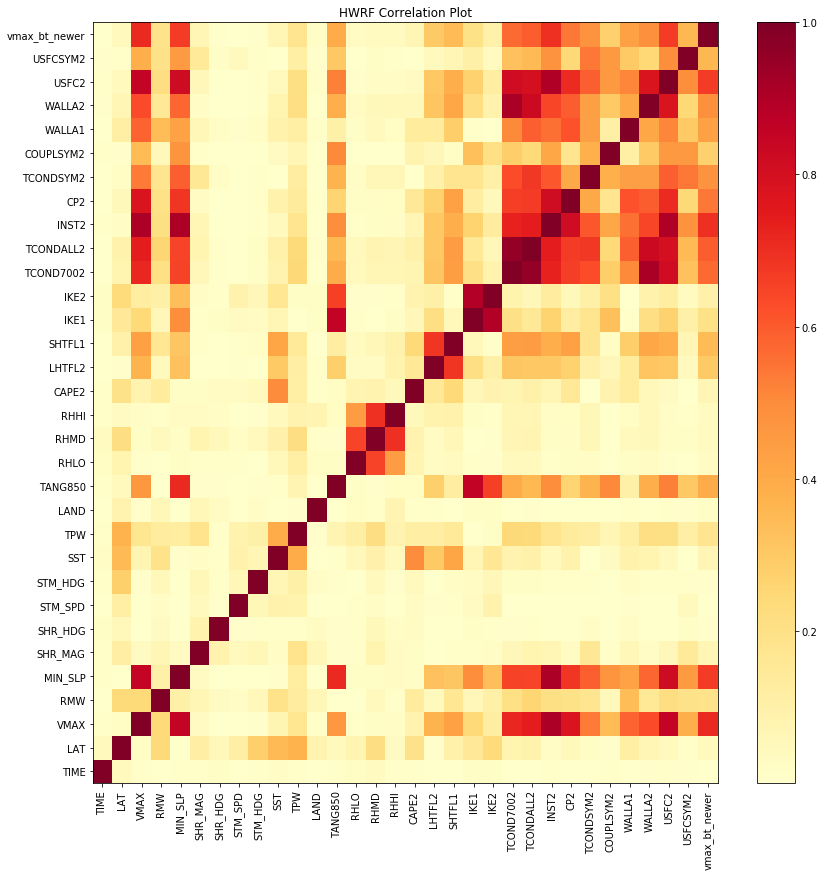

In [5]:
plt.figure(figsize=(14, 14))
plt.pcolormesh(np.corrcoef(train_data[input_cols + ["vmax_bt_newer"]].values.T) ** 2, cmap="YlOrRd")
_ = plt.yticks(np.arange(len(input_cols) + 1) + 0.5, input_cols + ["vmax_bt_newer"])
_ = plt.xticks(np.arange(len(input_cols) + 1) + 0.5, input_cols + ["vmax_bt_newer"], rotation=90)

plt.colorbar()
plt.title("HWRF Correlation Plot")
plt.savefig("hwrf_corr.png", dpi=200, bbox_inches="tight")

Text(0.5, 1.0, 'Training Correlations')

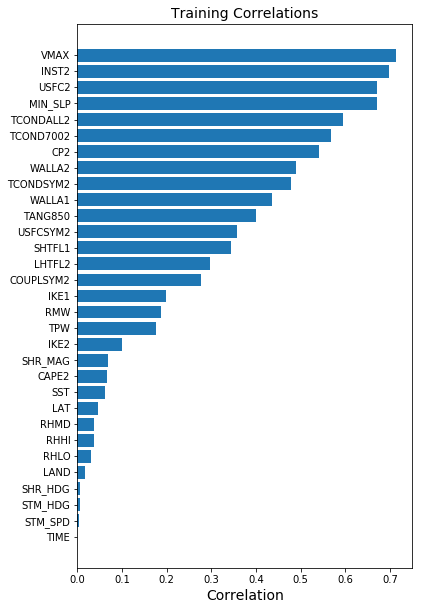

In [158]:
plt.figure(figsize=(6, 10))
vmax_corr = (np.corrcoef(train_data[input_cols + ["vmax_bt_newer"]].values.T) ** 2)[:-1, -1]
vmax_corr_ranks = np.argsort(vmax_corr)
plt.barh(np.arange(vmax_corr.shape[0]), vmax_corr[vmax_corr_ranks])
plt.yticks(np.arange(len(input_cols)), np.array(input_cols)[vmax_corr_ranks])
plt.xlabel("Correlation", fontsize=14)
plt.title("Training Correlations", fontsize=14)

In [18]:
dnn_g = DenseNeuralNet(hidden_layers=2, hidden_neurons=200, 
                       activation="relu", learning_rate=0.001, dropout_alpha=0.1, 
                       batch_size=256, output_type="linear", verbose=1, epochs=20)
dnn_g.fit(scaled_train, train_data["dvmax_bt_24"])

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 31)                0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 31)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 200)               6400      
_________________________________________________________________
hidden_scalar_activation_00  (None, 200)               0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 200)               40200     
_________________________________________________________________
hidden_scalar_activation_01  (None, 200)               0   

KeyboardInterrupt: 

In [12]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=4, max_features=2, criterion="mse")
rf.fit(scaled_train, train_data["vmax_bt_newer"])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=4, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [13]:
rf_preds = rf.predict(scaled_val)

In [14]:
g_out = dnn_g.predict(scaled_val)

In [23]:
hwrf_rmse = np.sqrt(mean_squared_error(val_data["vmax_bt_new"], val_data["VMAX"]))
print(hwrf_rmse)

18.984521150183355


In [15]:
dnn_mae = mean_absolute_error(val_data["vmax_bt_newer"], g_out[:, 0])
hwrf_mae = mean_absolute_error(val_data["vmax_bt_newer"], val_data["VMAX"])
rf_mae = mean_absolute_error(val_data["vmax_bt_newer"],rf_preds)
print(hwrf_mae, dnn_mae, rf_mae)

12.117383720930233 12.068155644882557 11.986104651162789


In [19]:
forecast_hours = np.sort(val_data["TIME"].unique())
maes = pd.DataFrame(0, index=forecast_hours, columns=["Neural Net", "Random Forest", "HWRF"])
counts = np.zeros(forecast_hours.size, dtype=int)
for f, fh in enumerate(forecast_hours):
    idxs = val_data["TIME"] == fh
    counts[f] = idxs.sum()
    maes.loc[fh, "Neural Net"] = mean_absolute_error(val_data.loc[idxs, "vmax_bt_newer"], g_out[idxs, 0])
    maes.loc[fh, "Random Forest"] = mean_absolute_error(val_data.loc[idxs, "vmax_bt_newer"], rf_preds[idxs])
    maes.loc[fh, "HWRF"] = mean_absolute_error(val_data.loc[idxs, "vmax_bt_newer"], val_data.loc[idxs, "VMAX"])

KeyError: 'vmax_bt_newer'

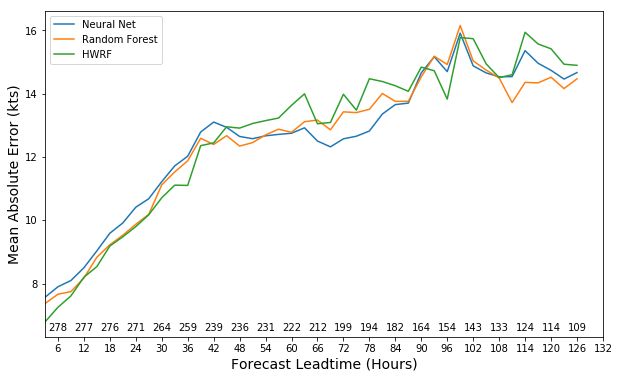

In [42]:
maes.plot(figsize=(10, 6))
plt.xlabel("Forecast Leadtime (Hours)", fontsize=14)
plt.ylabel("Mean Absolute Error (kts)", fontsize=14)
for f in np.arange(1, forecast_hours.size, 2):
    plt.text(forecast_hours[f], 6.5, "{0:d}".format(counts[f]), fontsize=10, ha="center")
plt.xticks(np.arange(6, 138, 6))
plt.savefig("hwrf_ml_maes.png", dpi=200, bbox_inches="tight")

([<matplotlib.axis.YTick at 0x133b69f60>,
 <a list of 31 Text yticklabel objects>)

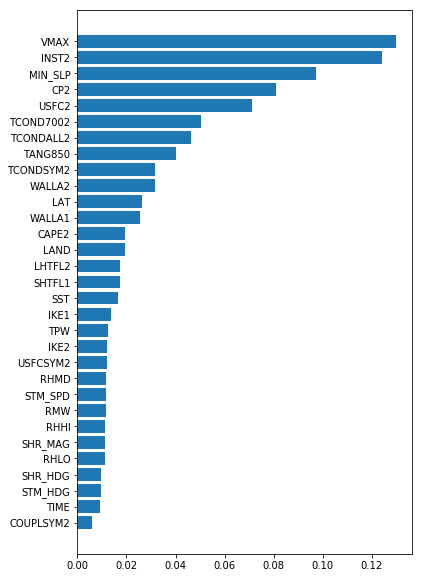

In [46]:
rf_ranks = np.argsort(rf.feature_importances_)
rf_vars = np.array(input_cols)[rf_ranks]
plt.figure(figsize=(6, 10))
plt.barh(np.arange(len(input_cols)), rf.feature_importances_[rf_ranks])
plt.yticks(np.arange(len(input_cols)), rf_vars)

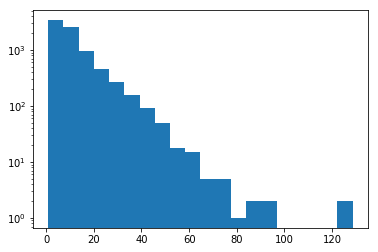

In [17]:
plt.hist(g_out[:, 1], bins=20)
plt.gca().set_yscale("log")

In [37]:
def crps_numpy(y_true, y_pred, bins=np.arange(0, 200, 5)):
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    bin_diffs = bins[1:] - bins[:-1]
    bin_range = bins[1] - bins[0]
    y_true_cdf = np.array(y_true.reshape(-1, 1) > bin_centers.reshape(1, -1), dtype=np.float32)
    y_pred_cdf = np.array([norm.cdf(bin_centers, loc=y_pred[i, 0], scale=y_pred[i, 1]) for i in range(y_pred.shape[0])])
    diff_sums = np.mean((y_true_cdf - y_pred_cdf) ** 2 * bin_diffs / bin_range , axis=1)
    return np.mean(diff_sums)
    
def permutation_feature_importance(input_data, output_data, model, score=crps_numpy):
    preds = model.predict(input_data)
    if len(preds.shape) == 2:
        preds = preds[:, 0]
    original_error = score(output_data, preds)
    permuted_scores = np.zeros(input_data.shape[1])
    permuted_data = np.copy(input_data)
    permuted_indices = np.arange(input_data.shape[0])
    for c in range(input_data.shape[1]):
        print(c)
        np.random.shuffle(permuted_indices)
        permuted_data[:, c] = input_data[permuted_indices, c]
        preds = model.predict(permuted_data)
        if len(preds.shape) == 2:
            preds = preds[:, 0]
        permuted_scores[c] = score(output_data, preds)
        permuted_data[:, c] = input_data[:, c]
    return original_error, permuted_scores

In [29]:
fi_rf = permutation_feature_importance(scaled_train, train_data["vmax_bt_newer"].values, rf, score=mean_absolute_error)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [79]:
fi

(0.9200449511188098,
 array([0.91490725, 0.90228906, 0.88788708, 0.91928273, 0.91007112,
        0.91769518, 0.9181683 , 0.91631986, 0.91603932, 0.91646768,
        0.91410306, 0.91114892, 0.84320343, 0.91619283, 0.91280526,
        0.91580119, 0.91349443, 0.91683868, 0.91379669, 0.88007933,
        0.91207681, 0.92049992, 0.9156835 , 0.91418619, 0.9130489 ,
        0.920133  , 0.91897141, 0.91796277, 0.91761465, 0.89617384,
        0.91819281]))

In [38]:
fi = permutation_feature_importance(scaled_train, train_data["vmax_bt_newer"].values, dnn_g, score=mean_absolute_error)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


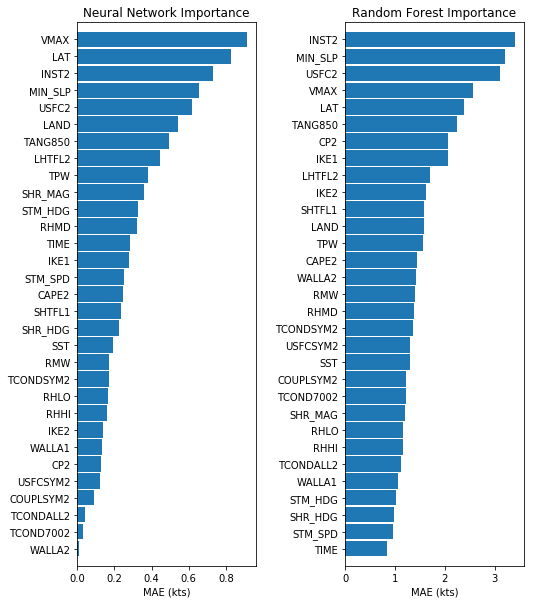

In [39]:
plt.figure(figsize=(8, 10))
plt.subplots_adjust(wspace=0.5)
plt.subplot(1, 2, 1)
ranks = np.argsort(fi[1] - fi[0])
plt.barh(np.arange(len(input_cols)), (fi[1] - fi[0])[ranks], height=0.9)

plt.yticks(np.arange(len(input_cols)), np.array(input_cols)[ranks])
plt.ylim(-1, len(input_cols))
plt.xlabel("MAE (kts)")
plt.title("Neural Network Importance")
plt.subplot(1, 2, 2)
rf_ranks = np.argsort(fi_rf[1] - fi_rf[0])
plt.barh(np.arange(len(input_cols)), (fi_rf[1] - fi_rf[0])[rf_ranks], height=0.9)

plt.yticks(np.arange(len(input_cols)), np.array(input_cols)[rf_ranks])
plt.ylim(-1, len(input_cols))
plt.title("Random Forest Importance")
plt.xlabel("MAE (kts)")
plt.savefig("hwrf_var_imps.png", dpi=200, bbox_inches="tight")

In [40]:
crps_numpy(val_data["vmax_bt_newer"].values, g_out)

0.8863370523463107

In [41]:
crps_numpy(train_data["vmax_bt_newer"].values, dnn_g.predict(scaled_train))

0.9148883391202852

In [47]:
np.unique(val_data["STNAM"] + "_" + val_data["BASIN"] + "_" + val_data["DATE"].astype(str).str[:4])

array(['bret_l_2017', 'eight_l_2016', 'eight_l_2017', 'ela_e_2015',
       'eleven_l_2015', 'fifteen_e_2016', 'fifteen_e_2017', 'four_e_2017',
       'fourteen_e_2015', 'fourteen_e_2017', 'fourteen_l_2017',
       'greg_e_2017', 'hilary_e_2017', 'ian_l_2016', 'joaquin_l_2015',
       'kate_l_2015', 'matthew_l_2016', 'nineteen_e_2015',
       'nineteen_l_2017', 'norma_e_2017', 'otto_l_2016', 'rina_l_2017',
       'roslyn_e_2016', 'sixteen_l_2016', 'sixteen_l_2017',
       'thirteen_e_2015', 'thirteen_e_2016', 'thirteen_e_2017',
       'thirteen_l_2017', 'three_e_2016', 'twelve_l_2016', 'two_e_2016'],
      dtype=object)

In [19]:
val_names = val_data["STNAM"] + "_" +  val_data["BASIN"] + "_" + val_data["DATE"].astype(str).str[:4]
storm_name = 'matthew_l_2016'
storm_index = val_names == storm_name
storm_run_dates = np.sort(val_data.loc[storm_index, "DATE"].unique())
print(storm_run_dates)

[2016092818 2016092900 2016092906 2016092912 2016092918 2016093000
 2016093006 2016093012 2016093018 2016100100 2016100106 2016100112
 2016100118 2016100200 2016100206 2016100212 2016100218 2016100300
 2016100306 2016100312 2016100318 2016100400 2016100406 2016100412
 2016100418 2016100500 2016100506 2016100512 2016100518 2016100600
 2016100606 2016100612 2016100618 2016100700 2016100706 2016100712
 2016100718 2016100800 2016100806 2016100812 2016100818 2016100900
 2016100906 2016100912 2016100918]


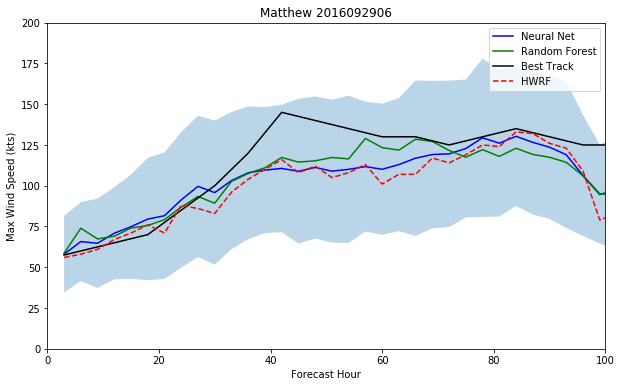

In [30]:
storm_run = storm_run_dates[2]
run_indices = (val_names  ==storm_name) & (val_data["DATE"] == storm_run)
run_preds = pd.DataFrame(g_out[run_indices], index=val_data.index[run_indices], 
                         columns=["vmax_nn_mean", "vmax_nn_sd"])
rf_pred_f = pd.DataFrame(rf_preds[run_indices], index=val_data.index[run_indices],
                         columns=["rf_mean"])
sorted_indices = np.sort(val_data.index[run_indices])
storm_val = val_data.loc[sorted_indices]
storm_preds = run_preds.loc[sorted_indices]
storm_preds_rf = rf_pred_f.loc[sorted_indices]
plt.figure(figsize=(10, 6))
plt.fill_between(storm_val["TIME"], storm_preds["vmax_nn_mean"] + 2 * storm_preds["vmax_nn_sd"],
                storm_preds["vmax_nn_mean"] - 2 * storm_preds["vmax_nn_sd"], alpha=0.3)
plt.plot(storm_val["TIME"], storm_preds["vmax_nn_mean"], 'b-', label="Neural Net")
plt.plot(storm_val["TIME"], storm_preds_rf["rf_mean"], 'g-', label="Random Forest")

plt.plot(storm_val["TIME"], storm_val["vmax_bt_newer"], 'k-', label="Best Track")
plt.plot(storm_val["TIME"], storm_val["VMAX"], 'r--', label="HWRF")
plt.xlabel("Forecast Hour")
plt.xlim(0, 100)
plt.ylim(0, 200)
plt.legend()
plt.ylabel("Max Wind Speed (kts)")
plt.title(storm_name.split("_")[0].capitalize() + " " + str(storm_run))
plt.savefig("storm_example.png", dpi=200, bbox_inches="tight")

In [21]:
def partial_dependence_1d(x, var_index=0, model=None, var_vals=None):
    """
    Calculate how the mean prediction of an ML model varies if one variable's value is fixed across all input
    examples.

    Args:
        x: array of input variables
        model: scikit-learn style model object
        var_index: column index of the variable being investigated
        var_vals: values of the input variable that are fixed.

    Returns:
        Array of partial dependence values.
    """
    partial_dependence = np.zeros((var_vals.shape[0], x.shape[0]), dtype=np.float32)
    x_copy = np.copy(x)
    for v, var_val in enumerate(var_vals):
        x_copy[:, var_index] = var_val
        partial_dependence[v] = model.predict(x_copy)[:, 0].ravel()
    return partial_dependence

In [22]:
def partial_dependence_1d_rf(x, var_index=0, model=None, var_vals=None):
    """
    Calculate how the mean prediction of an ML model varies if one variable's value is fixed across all input
    examples.

    Args:
        x: array of input variables
        model: scikit-learn style model object
        var_index: column index of the variable being investigated
        var_vals: values of the input variable that are fixed.

    Returns:
        Array of partial dependence values.
    """
    partial_dependence = np.zeros((var_vals.shape[0], x.shape[0]), dtype=np.float32)
    x_copy = np.copy(x)
    for v, var_val in enumerate(var_vals):
        x_copy[:, var_index] = var_val
        partial_dependence[v] = model.predict(x_copy).ravel()
    return partial_dependence

In [24]:
u_var_vals = scaler.inverse_transform(var_vals.T).T

In [23]:
x = scaled_train
pd_grid_count = 15
var_vals = np.zeros((len(input_cols), pd_grid_count), dtype=np.float32)
for j in range(var_vals.shape[0]):
    var_vals[j] = np.linspace(x[:, j].min(), x[:, j].max(), pd_grid_count)
pd_dnn = np.zeros((len(input_cols), var_vals.shape[1], x.shape[0]))
for j in range(x.shape[1]):
    print(j)
    pd_dnn[j] = partial_dependence_1d(x, var_index=j, model=dnn_g, var_vals=var_vals[j])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [195]:
x = scaled_train
pd_grid_count = 15
var_vals = np.zeros((len(input_cols), pd_grid_count), dtype=np.float32)
for j in range(var_vals.shape[0]):
    var_vals[j] = np.linspace(x[:, j].min(), x[:, j].max(), pd_grid_count)
pd_rf = np.zeros((len(input_cols), var_vals.shape[1], x.shape[0]))
for j in range(x.shape[1]):
    print(j)
    pd_rf[j] = partial_dependence_1d_rf(x, var_index=j, model=rf, var_vals=var_vals[j])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


0 TIME
1 LAT
2 VMAX
3 RMW
4 MIN_SLP
5 SHR_MAG
6 SHR_HDG
7 STM_SPD
8 STM_HDG
9 SST
10 TPW
11 LAND
12 TANG850
13 RHLO
14 RHMD
15 RHHI
16 CAPE2
17 LHTFL2
18 SHTFL1
19 IKE1
20 IKE2
21 TCOND7002
22 TCONDALL2
23 INST2
24 CP2
25 TCONDSYM2
26 COUPLSYM2
27 WALLA1
28 WALLA2
29 USFC2
30 USFCSYM2


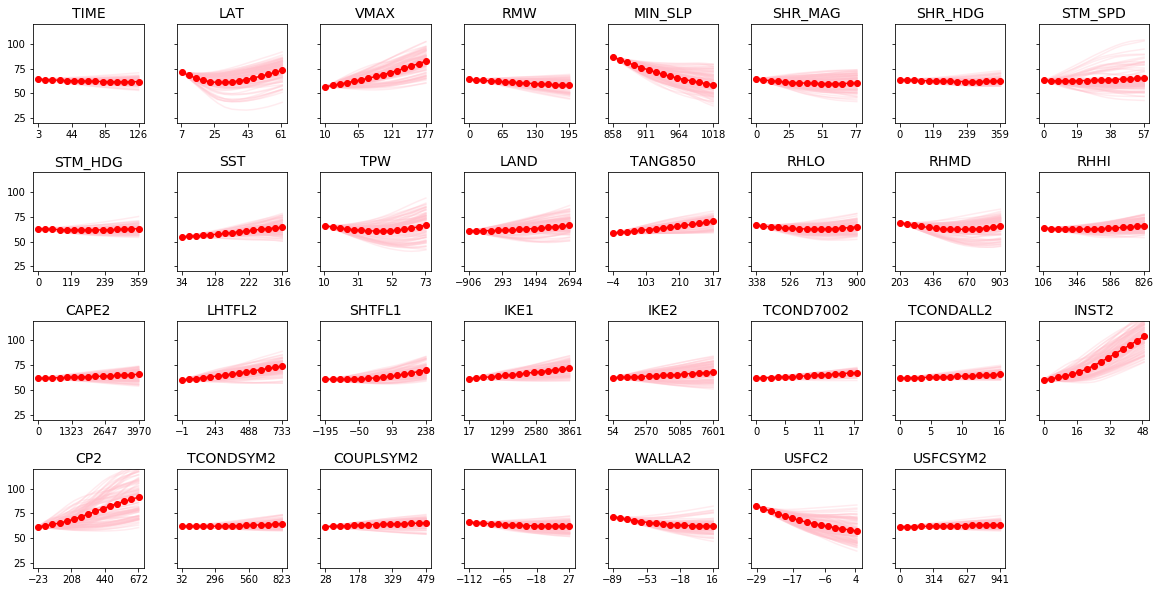

In [40]:
fig, axes = plt.subplots(4, 8, figsize=(20, 10), sharey=True)
axef = axes.ravel()
plt.subplots_adjust(wspace=0.3, hspace=0.5)
rand_i = np.random.randint(0, scaled_train.shape[0], 100)
for i, input_col in enumerate(input_cols):
    print(i, input_col)
    mean_start = pd_dnn[i].mean(axis=1)[0]
    mean_start_diff = pd_dnn[i, 0, rand_i].T - mean_start
    for r in range(100):
        axef[i].plot(u_var_vals[i], pd_dnn[i, :, rand_i[r]].T - mean_start_diff[r], color="pink", alpha=0.3)
    axef[i].plot(u_var_vals[i], pd_dnn[i].mean(axis=1), "ro-")
    axef[i].set_xticks(np.linspace(u_var_vals[i].min(), u_var_vals[i].max(), 4).astype(int))
    axef[i].set_title(input_col, fontsize=14)
    axef[i].set_ylim(20, 120)
axef[-1].axis("off")
plt.savefig("partial_dependence_nn.png", dpi=200, bbox_inches="tight")
    

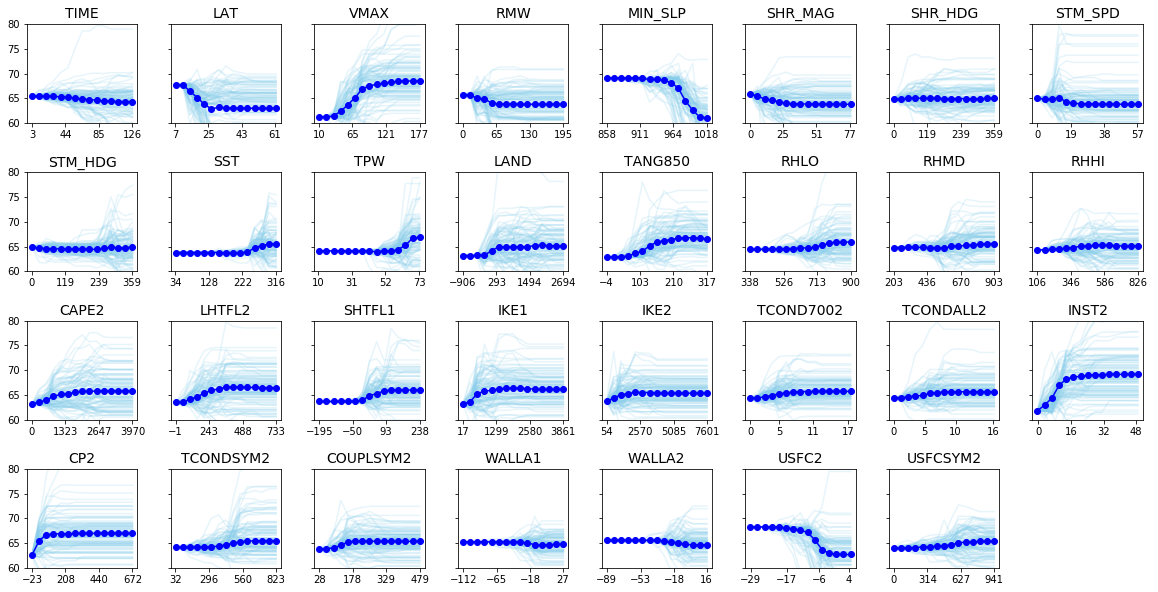

In [211]:
fig, axes = plt.subplots(4, 8, figsize=(20, 10), sharey=True)
axef = axes.ravel()
plt.subplots_adjust(wspace=0.3, hspace=0.5)
rand_i = np.random.randint(0, scaled_train.shape[0], 100)
for i, input_col in enumerate(input_cols):
    mean_start = pd_rf[i].mean(axis=1)[0]
    mean_start_diff = pd_rf[i, 0, rand_i].T - mean_start
    for r in range(100):
        axef[i].plot(u_var_vals[i], pd_rf[i, :, rand_i[r]] - mean_start_diff[r], color="skyblue", alpha=0.2)
    axef[i].plot(u_var_vals[i], pd_rf[i].mean(axis=1), "bo-")
    axef[i].set_xticks(np.linspace(u_var_vals[i].min(), u_var_vals[i].max(), 4).astype(int))
    axef[i].set_title(input_col, fontsize=14)
    axef[i].set_ylim(60, 80)
axef[-1].axis("off")
plt.savefig("partial_dependence_rf.png", dpi=200, bbox_inches="tight")

In [131]:
var_vals[17]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

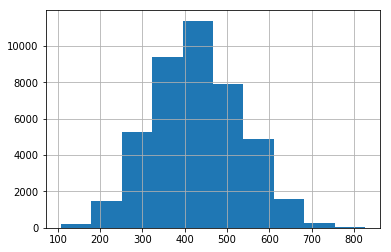

In [149]:
train_data["RHHI"].hist()

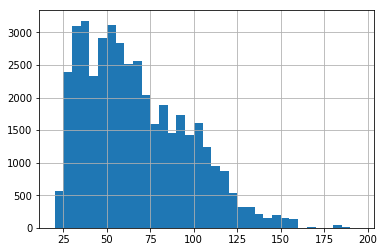

In [47]:
train_data["vmax_bt_newer"].hist(bins=np.arange(20, 200, 5))